# Week 8-1b 텍스트 분류 OpenAI batch

In [49]:
import numpy as np
import pandas as pd
import os

os.chdir(r'C:\Users\USER\kjw\LG전자_25\Week8')
spam=pd.read_csv("spam.csv",encoding='latin1')

In [50]:
spam

v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        NaN  
1           NaN        NaN  
2           NaN        NaN  
3           NaN        NaN  
4           NaN        NaN  
...         ...        ...  
5567        NaN        NaN  
5568        NaN        NaN  
5569        NaN        NaN  
5570        NaN        NaN  
5571        NaN        NaN  

[5572 rows x 5 columns]

In [51]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [52]:
spam.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1, inplace=True)

In [53]:
spam['v1'] =spam['v1'].replace(['ham','spam'],[0,1])

In [54]:
spam.head()

v1                                                 v2
0   0  Go until jurong point, crazy.. Available only ...
1   0                      Ok lar... Joking wif u oni...
2   1  Free entry in 2 a wkly comp to win FA Cup fina...
3   0  U dun say so early hor... U c already then say...
4   0  Nah I don't think he goes to usf, he lives aro...

In [55]:
spam.isnull().any() # null 존재 여부 확인

v1    False
v2    False
dtype: bool

In [56]:
spam['v1'].nunique() # 중복값 확인

2

In [57]:
spam['v2'].nunique() # 중복값 확인

5169

In [58]:
spam.drop_duplicates(subset=['v2'],inplace=True) # 중복제거

In [59]:
spam.shape

(5169, 2)

In [60]:
spam['v1'].value_counts()

0    4516
1     653
Name: v1, dtype: int64

<AxesSubplot:>

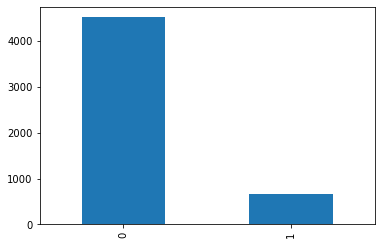

In [61]:
spam['v1'].value_counts().plot(kind='bar')

In [ ]:
# OpenAI batch 사용

In [63]:
emails = spam['v2'][:100]

# Few-shot 예시 프롬프트 (고정 부분)
few_shot_intro = """다음은 이메일 분류 예시입니다. 

예시 1:
이메일: "Free entry in 2 a weekly competition to win FA Cup final tickets!"
분류: 1

예시 2:
이메일: "Can we meet for lunch tomorrow?"
분류: 0

예시 3:
이메일: "WINNER!! As a valued network customer you have been selected to receive a reward!"
분류: 1

이제 다음 이메일을 분류하세요(스팸은 1, 햄은 0):
"""

In [22]:
# JSONL 파일 생성

import json
with open("spam_batch_input_fewshot.jsonl", "w", encoding="utf-8") as f:
    for i, email_text in enumerate(emails):
        prompt = few_shot_intro + f'이메일: "{email_text.strip()}"\n분류:'
        json.dump({
            "custom_id": f"email_{i}",
            "method": "POST",
            "url": "/v1/chat/completions",
            "body": {
                "model": "gpt-4o",
                "messages": [{"role": "user", "content": prompt}],
                "temperature": 0
            }
        }, f)
        f.write("\n")

In [ ]:
# chatgpt Platform 에서 Dashboard - Batches - Create 후에 생성된 json 파일 올리기

In [ ]:
# 하루(?) 후 Dashboard - Batches 에서 결과 json 파일 다운로드
# json 파일 -> csv 파일

In [1]:
import json
import csv

input_file = 'spam_batch_output_fewshot.jsonl'  # ChatGPT batch 결과 파일
output_file = 'spam_batch_output_fewshot.csv'   # 변환될 CSV 파일 이름

with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', newline='', encoding='utf-8') as outfile:
    fieldnames = [
        "id", "custom_id", "status_code", "request_id",
        "response_id", "model", "content",
        "prompt_tokens", "completion_tokens", "total_tokens"
    ]
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()

    for line in infile:
        data = json.loads(line)

        try:
            body = data["response"]["body"]
            usage = body.get("usage", {})
            choice = body["choices"][0]["message"]

            row = {
                "id": data.get("id"),
                "custom_id": data.get("custom_id"),
                "status_code": data["response"].get("status_code"),
                "request_id": data["response"].get("request_id"),
                "response_id": body.get("id"),
                "model": body.get("model"),
                "content": choice.get("content"),
                "prompt_tokens": usage.get("prompt_tokens"),
                "completion_tokens": usage.get("completion_tokens"),
                "total_tokens": usage.get("total_tokens"),
            }

            writer.writerow(row)

        except Exception as e:
            print(f"에러 발생: {e}")
            continue

print("CSV 변환 완료: spam_batch_output_fewshot.csv")

CSV 변환 완료: spam_batch_output_fewshot.csv


In [20]:
result_df=pd.read_csv("spam_batch_output_fewshot.csv")
result_df

id custom_id  status_code  \
0   batch_req_6827a277fa088190b234c44cdaae750d   email_0          200   
1   batch_req_6827a2781bb081909d8e0c911c0411e1   email_1          200   
2   batch_req_6827a2782ccc81908848af15c7d3f24b   email_2          200   
3   batch_req_6827a2783e4c8190b7fec72179d0a900   email_3          200   
4   batch_req_6827a27847f081908169008f5b681c5c   email_4          200   
..                                         ...       ...          ...   
95  batch_req_6827a27f3c3c819096a05acdba230826  email_95          200   
96  batch_req_6827a27f472081909fd8d64364c6426d  email_96          200   
97  batch_req_6827a27f647c8190948bc2ba93cabfed  email_97          200   
98  batch_req_6827a27f6e848190b1961579ebcfa511  email_98          200   
99  batch_req_6827a27f7cfc81909db918399f9b9091  email_99          200   

                          request_id                             response_id  \
0   2671e277dc67b04a00da5f2998f10834  chatcmpl-BXvnej79zbAHXMiYvfCm8qpYWsUwj   
1   e2b376f5722a8e593e9a3eeaf6886997  chatcmpl-BXvnhdcvPoADr2Xtvbk8WmvDvwPkq   
2   21aef843fc00c078f4a79585ee138c1a  chatcmpl-BXvnh8mNUiyjREqLaeDviEqTrVqPe   
3   75eff38fe6adc9913c03042f65008e00  chatcmpl-BXvneftcmGN0WSURFQQe4wmrt3A8r   
4   95b5747045d538a614715b53cddd2734  chatcmpl-BXvnfGknGTZCLztZwu3ZYI4IQrMkd   
..                               ...                                     ...   
95  24e38d012c937974c28b040ed5eb3f9a  chatcmpl-BXvngCG3CRieZ1WPBqLAkG8JV0Pp6   
96  76aaf2e610bb6d29037d9761bd29b7c7  chatcmpl-BXvne5EuhIRGfbJXV9LBFiOM2PBO9   
97  e53e30fad936980d72b7fba95566a740  chatcmpl-BXvnh9h6b9gyHrUnHMOWPOdMQK86v   
98  3ebcf98dc4aa17beb9ca988af7777e8c  chatcmpl-BXvnjwVhIu6Bx5S8Swyom7IqHWycS   
99  cd3763cad319311670ef5ad7b123deda  chatcmpl-BXvngAGXXOLmcXropS4KjllXBi7g6   

                model  content  prompt_tokens  completion_tokens  total_tokens  
0   gpt-4o-2024-08-06        0            157                  1           158  
1   gpt-4o-2024-08-06        0            141                  2           143  
2   gpt-4o-2024-08-06        1            182                  1           183  
3   gpt-4o-2024-08-06        0            144                  2           146  
4   gpt-4o-2024-08-06        0            147                  2           149  
..                ...      ...            ...                ...           ...  
95  gpt-4o-2024-08-06        1            164                  1           165  
96  gpt-4o-2024-08-06        0            141                  2           143  
97  gpt-4o-2024-08-06        0            145                  2           147  
98  gpt-4o-2024-08-06        0            183                  2           185  
99  gpt-4o-2024-08-06        0            144                  1           145  

[100 rows x 10 columns]

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print (' \n confusion_matrix chatGPT \n ')
cm = confusion_matrix(spam['v1'][:100], result_df['content'])
print (cm)
print ('\n Here is the classification report:')
print (classification_report(spam['v1'][:100], result_df['content']))

 
 confusion_matrix chatGPT 
 
[[80  3]
 [ 2 15]]

 Here is the classification report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        83
           1       0.83      0.88      0.86        17

    accuracy                           0.95       100
   macro avg       0.90      0.92      0.91       100
weighted avg       0.95      0.95      0.95       100



In [ ]:
# few shot (3 spam, 3 ham, chatgpt 제공)

In [34]:
spam_examples = [
    ("Congratulations! You've won a free cruise. Call now!", "1"),
    ("URGENT! You’ve won a $1000 Walmart gift card. Visit spamprizes.com", "1"),
    ("Win cash now!!! Click here: spamlink.biz", "1"),
]

ham_examples = [
    ("Hey, can we reschedule our meeting to Friday afternoon?", "0"),
    ("Please find attached the minutes from our last meeting.", "0"),
    ("Let's have lunch tomorrow at our usual place.", "0"),
]
# system message
system_msg = {
    "role": "system",
    "content": "You are a spam classifier. Reply with '1' for spam and '0' for ham. Respond with only one digit."
}

#  입력 저장용 리스트
batch_inputs = []

In [37]:
emails = spam[['v2']][:100]

for i, row in emails.iterrows():
    messages = [system_msg]

    # few-shot 예시 (순서: spam 3개, ham 3개)
    for text, label in spam_examples:
        messages.append({"role": "user", "content": f"Email: \"{text}\""})
        messages.append({"role": "assistant", "content": label})
    for text, label in ham_examples:
        messages.append({"role": "user", "content": f"Email: \"{text}\""})
        messages.append({"role": "assistant", "content": label})

    # 실제 분류 대상
    messages.append({"role": "user", "content": f"Email: \"{row['v2']}\""})

    body = {
        "model": "gpt-4",  # 또는 "gpt-3.5-turbo"
        "messages": messages,
        "temperature": 0
    }

    entry = {
        "custom_id": f"email_{i}",
        "method": "POST",
        "url": "/v1/chat/completions",
        "body": body
    }

    batch_inputs.append(entry)

# JSONL 파일로 저장
with open("batch_spam_fewshot6.jsonl", "w", encoding="utf-8") as f:
    for item in batch_inputs:
        json.dump(item, f)
        f.write("\n")

print("batch_spam_fewshot6.jsonl 파일 생성 완료!")

batch_spam_fewshot6.jsonl 파일 생성 완료!


In [ ]:
# chatgpt Platform 에서 Dashboard - Batches - Create 후에 생성된 json 파일 올리기

In [ ]:
# 하루 후 Dashboard - Batches 에서 결과 json 파일 다운로드
# json 파일 -> csv 파일

In [38]:
import json
import csv

input_file = 'spam_batch_output_fewshot6.jsonl'  # ChatGPT batch 결과 파일
output_file = 'spam_batch_output_fewshot6.csv'   # 변환될 CSV 파일 이름

with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', newline='', encoding='utf-8') as outfile:
    fieldnames = [
        "id", "custom_id", "status_code", "request_id",
        "response_id", "model", "content",
        "prompt_tokens", "completion_tokens", "total_tokens"
    ]
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()

    for line in infile:
        data = json.loads(line)

        try:
            body = data["response"]["body"]
            usage = body.get("usage", {})
            choice = body["choices"][0]["message"]

            row = {
                "id": data.get("id"),
                "custom_id": data.get("custom_id"),
                "status_code": data["response"].get("status_code"),
                "request_id": data["response"].get("request_id"),
                "response_id": body.get("id"),
                "model": body.get("model"),
                "content": choice.get("content"),
                "prompt_tokens": usage.get("prompt_tokens"),
                "completion_tokens": usage.get("completion_tokens"),
                "total_tokens": usage.get("total_tokens"),
            }

            writer.writerow(row)

        except Exception as e:
            print(f"에러 발생: {e}")
            continue

print("CSV 변환 완료: spam_batch_output_fewshot6.csv")

CSV 변환 완료: spam_batch_output_fewshot6.csv


In [39]:
result_df=pd.read_csv("spam_batch_output_fewshot6.csv")
result_df

id custom_id  status_code  \
0   batch_req_6828829abef4819093d564463f4be3a4   email_0          200   
1   batch_req_6828829acca88190970c87c93a119cb0   email_1          200   
2   batch_req_6828829adba08190875e7f296b9df136   email_2          200   
3   batch_req_6828829ae9ac8190be9f85294f4292ac   email_3          200   
4   batch_req_6828829af77c81909cbdc0eb13cdcb88   email_4          200   
..                                         ...       ...          ...   
95  batch_req_682882a069b88190bdbf22ea48192130  email_95          200   
96  batch_req_682882a078a08190b7f8f2177b28a28b  email_96          200   
97  batch_req_682882a089e48190b84ea60ff45154f1  email_97          200   
98  batch_req_682882a09aec8190830eabff17602427  email_98          200   
99  batch_req_682882a0ad2081909868f2067afa4a3f  email_99          200   

                          request_id                             response_id  \
0   5b803bdb475582d54d33f9f0f10e2f20  chatcmpl-BYAxP0illaVO115qtOoV02CRub9jy   
1   74131f55a7d553c86bd8bbddc06c3527  chatcmpl-BYB3J2p4cjWajRh8RWO4c5vOyKcoH   
2   7734608ede7e4eecf84a4f56891cabaa  chatcmpl-BYB3Jcyw2m3AMXiDtedw18eQbL19s   
3   901716f0621c2e33c29b0bdc820a2749  chatcmpl-BYB3Jn6Y44dp63CrZq9a7kxsNBkQn   
4   97262248e858df2687e0524e9ee470d4  chatcmpl-BYB3JHCVpF8SgerEsGO2ZFOgNIw3d   
..                               ...                                     ...   
95  1c262f790fdf008479d868e1537b117e  chatcmpl-BYAyWXzloZHWSa24leMPB2j8LDkHN   
96  bcb7c2f24aed7eea27bf7db1f5a32fc7  chatcmpl-BYAyZNx6ifQarNtUlbBFUOF6LXqdW   
97  97860bc21766ac1a28fcba7d41662112  chatcmpl-BYAyWYLBdYOgVEgoN0sq0SdJ0Fgqk   
98  427674f2982d2662d25fc3028f080d16  chatcmpl-BYAyXklSv2wmWLS5KfC1ZBL0Mlwka   
99  94b9d0a13bfc54f0932d08e59214a231  chatcmpl-BYAyXl4ND20WJHbKSAFoPVA9GjmbD   

         model  content  prompt_tokens  completion_tokens  total_tokens  
0   gpt-4-0613        0            215                  1           216  
1   gpt-4-0613        0            199                  1           200  
2   gpt-4-0613        1            239                  1           240  
3   gpt-4-0613        0            201                  1           202  
4   gpt-4-0613        0            206                  1           207  
..         ...      ...            ...                ...           ...  
95  gpt-4-0613        1            222                  1           223  
96  gpt-4-0613        0            198                  1           199  
97  gpt-4-0613        0            202                  1           203  
98  gpt-4-0613        0            239                  1           240  
99  gpt-4-0613        0            202                  1           203  

[100 rows x 10 columns]

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print (' \n confusion_matrix chatGPT \n ')
cm = confusion_matrix(spam['v1'][:100], result_df['content'])
print (cm)
print ('\n Here is the classification report:')
print (classification_report(spam['v1'][:100], result_df['content']))

 
 confusion_matrix chatGPT 
 
[[79  4]
 [ 1 16]]

 Here is the classification report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97        83
           1       0.80      0.94      0.86        17

    accuracy                           0.95       100
   macro avg       0.89      0.95      0.92       100
weighted avg       0.96      0.95      0.95       100



In [ ]:
# few shot (3 spam, 3 ham, test에 없는 예제 제공(맨 아래에서 각각 3개씩 추출))

In [42]:
spam_examples = [
    ("This is the 2nd time we have tried 2 contact u. U have won the 鶯750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.", "1"),
    ("REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode", "1"),
    ("Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records.", "1"),
]

ham_examples = [
    ("Rofl. Its true to its name", "0"),
    ("The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free", "0"),
    ("Pity, * was in mood for that. So...any other suggestions?", "0"),
]
# system message
system_msg = {
    "role": "system",
    "content": "You are a spam classifier. Reply with '1' for spam and '0' for ham. Respond with only one digit."
}

#  입력 저장용 리스트
batch_inputs = []

In [43]:
emails = spam[['v2']][:100]

for i, row in emails.iterrows():
    messages = [system_msg]

    # few-shot 예시 (순서: spam 3개, ham 3개)
    for text, label in spam_examples:
        messages.append({"role": "user", "content": f"Email: \"{text}\""})
        messages.append({"role": "assistant", "content": label})
    for text, label in ham_examples:
        messages.append({"role": "user", "content": f"Email: \"{text}\""})
        messages.append({"role": "assistant", "content": label})

    # 실제 분류 대상
    messages.append({"role": "user", "content": f"Email: \"{row['v2']}\""})

    body = {
        "model": "gpt-4",  # 또는 "gpt-3.5-turbo"
        "messages": messages,
        "temperature": 0
    }

    entry = {
        "custom_id": f"email_{i}",
        "method": "POST",
        "url": "/v1/chat/completions",
        "body": body
    }

    batch_inputs.append(entry)

# JSONL 파일로 저장
with open("batch_spam_fewshot6_1.jsonl", "w", encoding="utf-8") as f:
    for item in batch_inputs:
        json.dump(item, f)
        f.write("\n")

print("batch_spam_fewshot6_1.jsonl 파일 생성 완료!")

batch_spam_fewshot6_1.jsonl 파일 생성 완료!


In [ ]:
# chatgpt Platform 에서 Dashboard - Batches - Create 후에 생성된 json 파일 올리기

In [ ]:
# 하루 후 Dashboard - Batches 에서 결과 json 파일 다운로드
# json 파일 -> csv 파일

In [44]:
import json
import csv

input_file = 'spam_batch_output_fewshot6.jsonl'  # ChatGPT batch 결과 파일
output_file = 'spam_batch_output_fewshot6.csv'   # 변환될 CSV 파일 이름

with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', newline='', encoding='utf-8') as outfile:
    fieldnames = [
        "id", "custom_id", "status_code", "request_id",
        "response_id", "model", "content",
        "prompt_tokens", "completion_tokens", "total_tokens"
    ]
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()

    for line in infile:
        data = json.loads(line)

        try:
            body = data["response"]["body"]
            usage = body.get("usage", {})
            choice = body["choices"][0]["message"]

            row = {
                "id": data.get("id"),
                "custom_id": data.get("custom_id"),
                "status_code": data["response"].get("status_code"),
                "request_id": data["response"].get("request_id"),
                "response_id": body.get("id"),
                "model": body.get("model"),
                "content": choice.get("content"),
                "prompt_tokens": usage.get("prompt_tokens"),
                "completion_tokens": usage.get("completion_tokens"),
                "total_tokens": usage.get("total_tokens"),
            }

            writer.writerow(row)

        except Exception as e:
            print(f"에러 발생: {e}")
            continue

print("CSV 변환 완료: spam_batch_output_fewshot6_1.csv")

CSV 변환 완료: spam_batch_output_fewshot6_1.csv


In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print (' \n confusion_matrix chatGPT \n ')
cm = confusion_matrix(spam['v1'][:100], result_df['content'])
print (cm)
print ('\n Here is the classification report:')
print (classification_report(spam['v1'][:100], result_df['content']))

 
 confusion_matrix chatGPT 
 
[[79  4]
 [ 1 16]]

 Here is the classification report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97        83
           1       0.80      0.94      0.86        17

    accuracy                           0.95       100
   macro avg       0.89      0.95      0.92       100
weighted avg       0.96      0.95      0.95       100

